# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, we might want to include an image classifier in a smart phone app. To do this, we will use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, we'll train an image classifier to recognize different species of flowers. We can imagine using something like this in a phone app that tells us the name of the flower our camera is looking at. In practice we will train this classifier, then export it for use in our application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, we can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on our dataset
* Use the trained classifier to predict image content


Upon completion of this project, there will be an application that can be trained on any set of labeled images. Here our network will be learning about flowers and end up as a command line application. 

In [23]:
# Importing packages needed for this porject here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import PIL
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models
import json
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from PIL import Image
from matplotlib.ticker import FormatStrFormatter
from torch.autograd import Variable
from collections import OrderedDict
import seaborn as sns
import time

## Load the data

Here we'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The dataset is split into three parts, training, validation, and testing. For the training, we will apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We will also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but we'll need to resize then crop the images to the appropriate size.

The pre-trained networks we'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
#Uploading the traning, validation and testing dataset
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
#Defining our transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
                                      


#Loading the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir ,transform = test_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)

#Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=True)

### Label mapping

We'll also need to load in a mapping from category label to category name. We can find this in the file `cat_to_name.json`. It's a JSON object which we can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, we should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If we need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

When training we are going to make sure we're updating only the weights of the feed-forward network. We should be able to get the validation accuracy above 70% if we build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.


## Testing the network

It's good practice to test our trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way we did validation. We should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [5]:
#Declaring our pretrained model
model = models.vgg16(pretrained=True)
device = torch.device("cuda")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:19<00:00, 27902621.07it/s]


In [6]:
for device in ['cpu', 'cuda']:

    criterion = nn.NLLLoss()
    # Only train the classifier parameters, feature parameters are frozen
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

    model.to(device)

    for ii, (inputs, labels) in enumerate(trainloader):

        # Move input and label tensors to the GPU
        inputs, labels = inputs.to(device), labels.to(device)

        start = time.time()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if ii==3:
            break
        
    print(f"Device = {device}; Time per batch: {(time.time() - start)/3:.3f} seconds")

Device = cpu; Time per batch: 16.898 seconds
Device = cuda; Time per batch: 0.127 seconds


In [7]:
#Building and training our network
#Use GPU if it's available
device = torch.device("cuda")

model = models.vgg16(pretrained=True)

for parameter in model.parameters():
    parameter.requires_grad = False
    
input_size = model.classifier[0].in_features
hidden_inputs = [2048, 1024]
output_size = len(cat_to_name)

classifier = nn.Sequential(nn.Linear(25088, 2048),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(2048, 1024),
                      nn.ReLU(),
                      nn.Dropout(p=0.2),
                      nn.Linear(1024, 102),
                      nn.LogSoftmax(dim=1))

print("input_size",'=',input_size)
print("hidden_inputs",'=',hidden_inputs)
print("output_size",'=',output_size)

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(type(images))
print(images.shape)
print(labels.shape)

model.classifier = classifier


input_size = 25088
hidden_inputs = [2048, 1024]
output_size = 102
<class 'torch.Tensor'>
torch.Size([32, 3, 224, 224])
torch.Size([32])


In [8]:
#Declaring criterion and optimizer
model = model.to('cuda')
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

In [9]:
#Importing images and labels of the data to the model
images, labels = images.to(device), labels.to(device)

In [10]:
#Training our feedforward network
epochs = 5
steps = 0
running_loss = 0
print_every = 50

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Moving input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculating accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/5.. Train loss: 4.168.. Test loss: 2.921.. Test accuracy: 0.303
Epoch 1/5.. Train loss: 2.623.. Test loss: 1.889.. Test accuracy: 0.493
Epoch 1/5.. Train loss: 2.103.. Test loss: 1.410.. Test accuracy: 0.606
Epoch 1/5.. Train loss: 1.730.. Test loss: 1.242.. Test accuracy: 0.656
Epoch 2/5.. Train loss: 1.565.. Test loss: 1.238.. Test accuracy: 0.672
Epoch 2/5.. Train loss: 1.606.. Test loss: 0.964.. Test accuracy: 0.740
Epoch 2/5.. Train loss: 1.450.. Test loss: 0.987.. Test accuracy: 0.717
Epoch 2/5.. Train loss: 1.432.. Test loss: 0.839.. Test accuracy: 0.768
Epoch 3/5.. Train loss: 1.248.. Test loss: 0.820.. Test accuracy: 0.774
Epoch 3/5.. Train loss: 1.229.. Test loss: 0.844.. Test accuracy: 0.765
Epoch 3/5.. Train loss: 1.268.. Test loss: 0.780.. Test accuracy: 0.770
Epoch 3/5.. Train loss: 1.242.. Test loss: 0.776.. Test accuracy: 0.790
Epoch 4/5.. Train loss: 1.107.. Test loss: 0.729.. Test accuracy: 0.789
Epoch 4/5.. Train loss: 1.180.. Test loss: 0.714.. Test accuracy

In [11]:
#Doing validation on the test set
total = 0
correct = 0

with torch.no_grad ():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model (inputs)
        _, predicted = torch.max (outputs.data,1)
        total += labels.size (0)
        correct += (predicted == labels).sum().item()
        
print("Accuracy obtained on the testing data - {:.3f}".format((100 * correct) / total))
    

Accuracy obtained on the testing data - 78.632


## Save the checkpoint

Now that the network is trained, we are going to save the model so we can load it later for making predictions. We probably want to save other things such as the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. We can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that we'll want to completely rebuild the model later so we can use it for inference. We are going to make sure to include any information we need in the checkpoint. If we want to load the model and keep training, we'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. We'll likely want to use this trained model in the next part of the project, so best to save it now.

In [13]:
# Save the checkpoint 
# Create this `class_to_idx` attribute 
model.class_to_idx = train_data.class_to_idx
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())


Our model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [12]:
#Defining the checkpoint parameters
checkpoint = {'epochs': 5,
              'classifier': classifier,
              'state_dict': model.state_dict(),
              'optimizer_dict': optimizer.state_dict(),
              'class_to_idx': train_data.class_to_idx,
             }

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [14]:
#Writing a function that loads a checkpoint and rebuilds the model
def load_checkpoint():
    """
    Loads deep learning model checkpoint.
    """
    
    # Load the saved file
    checkpoint = torch.load("'my_checkpoint.pth")
    
    # Download pretrained model
    model = models.vgg16(pretrained=True);
    
    # Freeze parameters so we don't backprop through them
    for param in model.parameters(): param.requires_grad = False
    
    # Load stuff from checkpoint
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])

    
    return model

# Inference for classification

Now we'll write a function to use a trained network for inference. That is, we'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First we'll need to handle processing the input image such that it can be used in our network. 

## Image Preprocessing

We'll  use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then we'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. We'll need to convert the values. It's easiest with a Numpy array, which we can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. We'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. We can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [15]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    test_image = PIL.Image.open(image)

    # Get original dimensions
    orig_width, orig_height = test_image.size

    # Find shorter size and create settings to crop shortest side to 256
    if orig_width < orig_height: resize_size=[256, 256**600]
    else: resize_size=[256**600, 256]
        
    test_image.thumbnail(size=resize_size)

    # Find pixels to crop on to create 224x224 image
    center = orig_width/4, orig_height/4
    left, top, right, bottom = center[0]-(244/2), center[1]-(244/2), center[0]+(244/2), center[1]+(244/2)
    test_image = test_image.crop((left, top, right, bottom))

    # Converrt to numpy - 244x244 image w/ 3 channels (RGB)
    np_image = np.array(test_image)/255 # Divided by 255 because imshow() expects integers (0:1)!!

    # Normalize each color channel
    normalise_means = [0.485, 0.456, 0.406]
    normalise_std = [0.229, 0.224, 0.225]
    np_image = (np_image-normalise_means)/normalise_std
        
    # Set the color to the first channel
    np_image = np_image.transpose(2, 0, 1)
    
    return np_image

To check our work, the function below converts a PyTorch tensor and displays it in the notebook. If our `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [15]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once we get images in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. We need to convert from these indices to the actual class labels using `class_to_idx` which hopefully we added to the model or from an `ImageFolder` we used to load the data ([see here](#Save-the-checkpoint)). We will make sure to invert the dictionary so we get a mapping from index to class as well.

Again, this method will take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [26]:
def predict(image_path, model, top_k=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
    image_path: string. Path to image, directly to image and not to folder.
    model: pytorch neural network.
    top_k: integer. The top K classes to be calculated
    
    returns top_probabilities(k), top_labels
    '''
    
    # No need for GPU on this part (just causes problems)
    model.to("cpu")
    
    # Set model to evaluate
    model.eval();

    # Convert image from numpy to torch
    torch_image = torch.from_numpy(np.expand_dims(process_image(image_path), 
                                                  axis=0)).type(torch.FloatTensor).to("cpu")

    # Find probabilities (results) by passing through the function (note the log softmax means that its on a log scale)
    log_probs = model.forward(torch_image)

    # Convert to linear scale
    linear_probs = torch.exp(log_probs)

    # Find the top 5 results
    top_probs, top_labels = linear_probs.topk(top_k)
    
    # Detatch all of the details
    top_probs = np.array(top_probs.detach())[0] # This is not the correct way to do it but the correct way isnt working thanks to cpu/gpu issues so I don't care.
    top_labels = np.array(top_labels.detach())[0]
    
    # Convert to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labels]
    top_flowers = [cat_to_name[lab] for lab in top_labels]
    
    return top_probs, top_labels, top_flowers

## Sanity Checking

Now that we can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

We can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

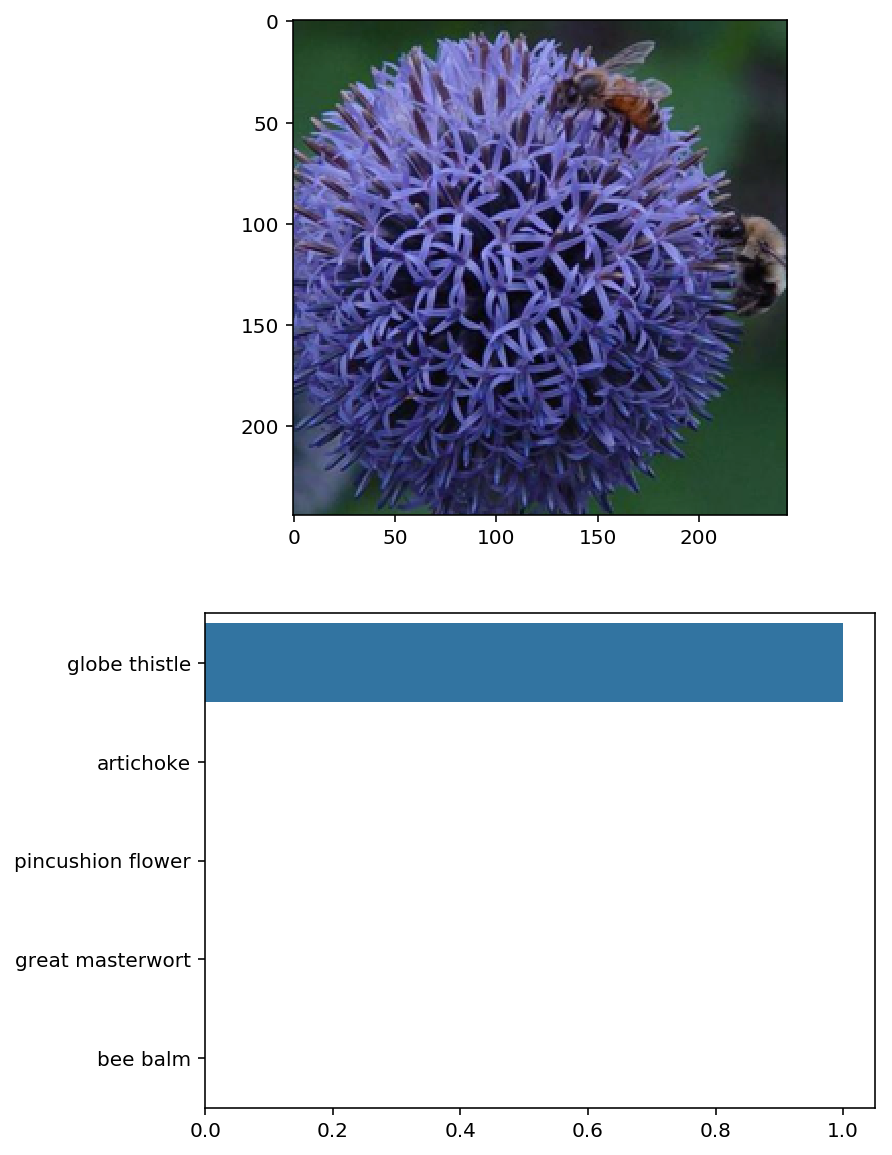

In [27]:
# Display an image along with the top 5 classes
# Define image path
image_path = "flowers/test/10/image_07090.jpg"

# Set up plot
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)

# Set up title
flower_num = image_path.split('/')[2]
title_ = cat_to_name[flower_num]

# Plot flower
img = process_image(image_path)
imshow(img, ax, title = title_);

# Make prediction
probs, labs, flowers = predict(image_path, model) 

# Plot bar chart
plt.subplot(2,1,2)
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
plt.show()